<a href="https://colab.research.google.com/github/MadmanMarble/MadmanMarble/blob/main/multi_class_U_Net_Model_(11_march_2024).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# multi-class u-net model

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [3]:
pip install rasterio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 58.0 MB/s eta 0:00:00


In [4]:
import rasterio

In [5]:
from sklearn.model_selection import train_test_split
import shutil

In [6]:
# Ensure the lists are sorted so that images and labels correspond to each other
planet_labels = sorted(glob.glob(f"/content/drive/MyDrive/DeepLearning_Project/unet_planet_data/planet_labels/*.tif"))
planet_images = sorted(glob.glob(f"/content/drive/MyDrive/DeepLearning_Project/unet_planet_data/planet_images/*.tif"))

# Split the file paths into training and testing sets (80% train, 20% test)
train_images_paths, test_images_paths, train_labels_paths, test_labels_paths = train_test_split(
    planet_images, planet_labels, test_size=0.2, random_state=42)

In [7]:
# List of files to copy
# files_to_copy = ['path/to/source/file1.txt', 'path/to/source/file2.jpg', 'path/to/source/file3.pdf']
# Destination directory
destination = '/content/train_images'

# Ensure the destination directory exists
os.makedirs(destination, exist_ok=True)

# Loop through the list and copy each file
for file in train_images_paths:
    # Define the full destination path for the current file
    dest_file = os.path.join(destination, os.path.basename(file))
    # Copy the file
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')



# Destination directory
destination = '/content/train_labels'

# Ensure the destination directory exists
os.makedirs(destination, exist_ok=True)

# Loop through the list and copy each file
for file in train_labels_paths:
    # Define the full destination path for the current file
    dest_file = os.path.join(destination, os.path.basename(file))
    # Copy the file
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

# Destination directory
destination = '/content/test_images'

# Ensure the destination directory exists
os.makedirs(destination, exist_ok=True)

# Loop through the list and copy each file
for file in test_images_paths:
    # Define the full destination path for the current file
    dest_file = os.path.join(destination, os.path.basename(file))
    # Copy the file
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')


# Destination directory
destination = '/content/test_labels'

# Ensure the destination directory exists
os.makedirs(destination, exist_ok=True)

# Loop through the list and copy each file
for file in test_labels_paths:
    # Define the full destination path for the current file
    dest_file = os.path.join(destination, os.path.basename(file))
    # Copy the file
    shutil.copy(file, dest_file)
    print(f'Copied {file} to {dest_file}')

Streaming output truncated to the last 5000 lines.
Copied /content/drive/MyDrive/DeepLearning_Project/unet_planet_data/planet_images/311_planet_stack_utm4.tif to /content/train_images/311_planet_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/unet_planet_data/planet_images/2455_planet_stack_utm4.tif to /content/train_images/2455_planet_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/unet_planet_data/planet_images/1592_planet_stack_utm4.tif to /content/train_images/1592_planet_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/unet_planet_data/planet_images/801_planet_stack_utm4.tif to /content/train_images/801_planet_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/unet_planet_data/planet_images/1569_planet_stack_utm4.tif to /content/train_images/1569_planet_stack_utm4.tif
Copied /content/drive/MyDrive/DeepLearning_Project/unet_planet_data/planet_images/650_planet_stack_utm4.tif to /content/train_images/650_planet_stac

In [8]:

test_images = sorted(glob.glob(f"/content/test_images/*.tif"))
test_labels = sorted(glob.glob(f"/content/test_labels/*.tif"))


train_images = sorted(glob.glob(f"/content/train_images/*.tif"))
train_labels = sorted(glob.glob(f"/content/train_labels/*.tif"))


In [58]:
#Resizing images, if needed
SIZE_X = 128
SIZE_Y = 128
n_classes= 13 #Number of classes for segmentation
batch_size = 8 #64

img_size = (SIZE_X, SIZE_Y)

In [10]:
# from tensorflow.keras.utils import Sequence, to_categorical
# import numpy as np
# import rasterio
# import cv2

# class DataGenerator(Sequence):
#     def __init__(self, image_files, label_files, img_height, img_width, batch_size, num_classes):
#         self.image_files = image_files
#         self.label_files = label_files
#         self.img_height = img_height
#         self.img_width = img_width
#         self.batch_size = batch_size
#         self.num_classes = num_classes


#     def __len__(self):
#         return int(np.ceil(len(self.image_files) / self.batch_size))

#     def __getitem__(self, index):
#         # Determine batch file paths
#         image_batch_files = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
#         label_batch_files = self.label_files[index * self.batch_size : (index + 1) * self.batch_size]
#         # Load and process images and labels
#         batch_images, batch_labels = self.load_images_and_labels(image_batch_files, label_batch_files)
#         return batch_images, batch_labels

#     def load_and_reshape_image(self, image_path, normalize=True):
#         with rasterio.open(image_path) as src:
#             image = src.read().transpose((1, 2, 0))
#             if image.shape[:2] != (self.img_height, self.img_width):
#                 image = cv2.resize(image, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)

#             if normalize:
#                 # Normalize the image data to 0-1 range
#                 image = image.astype(np.float32) / 255.0

#         return image


#     def load_images_and_labels(self, image_files, label_files):
#         images = []
#         labels = []

#         for image_file in image_files:
#             image = self.load_and_reshape_image(image_file)
#             images.append(image)

#         for label_file in label_files:
#             label = self.load_and_reshape_image(label_file, normalize=False)
#             label = label.astype(np.uint8)
#             label = to_categorical(label, num_classes=self.num_classes)
#             labels.append(label)

#         # images = [self.load_and_reshape_image(image_file) for image_file in image_files]
#         # labels = [self.load_and_reshape_image(label_file, normalize=False) for label_file in label_files]
#         # # Here, assuming labels are categorical and do not require normalization like images
#         # # For segmentation tasks, ensure labels are processed according to your task requirements
#         # labels = [to_categorical(label, num_classes=self.num_classes) for label in labels]
#         return np.array(images), np.array(labels)


In [11]:
from tensorflow.keras.utils import Sequence, to_categorical
import numpy as np
import rasterio
import cv2

class DataGenerator(Sequence):
    def __init__(self, image_files, label_files, img_height, img_width, batch_size, num_classes):
        self.image_files = image_files
        self.label_files = label_files
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.num_classes = num_classes

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))

    def __getitem__(self, index):
        image_batch_files = self.image_files[index * self.batch_size : (index + 1) * self.batch_size]
        label_batch_files = self.label_files[index * self.batch_size : (index + 1) * self.batch_size]

        batch_images, batch_labels = self.load_images_and_labels(image_batch_files, label_batch_files)
        return batch_images, batch_labels

    def load_and_reshape_image(self, image_path):
        with rasterio.open(image_path) as src:
            image = src.read().transpose((1, 2, 0))
            if image.shape[:2] != (self.img_height, self.img_width):
                image = cv2.resize(image, (self.img_width, self.img_height), interpolation=cv2.INTER_NEAREST)
        return image

    # def z_score_normalization(self, image):
    #     # epsilon = 1e-7
    #     # mean = np.mean(image, axis=(0, 1), keepdims=True)
    #     # std = np.std(image, axis=(0, 1), keepdims=True)
    #     # std[std < 0] = 0
    #     # normalized_image = (image - mean) / (std + epsilon)

    #     min = np.min(image, axis=(0, 1), keepdims=True)
    #     max = np.max(image, axis=(0, 1), keepdims=True)
    #     normalized_image = (image - min) / (max - min)


    #     return normalized_image

    def z_score_normalization(self, image):
        image = image.astype(np.float32)  # Ensure the image is in float format to handle division and large ranges

        min_val = np.min(image, axis=(0, 1), keepdims=True)
        max_val = np.max(image, axis=(0, 1), keepdims=True)
        range_val = max_val - min_val

        # Avoid division by zero by checking if range is 0
        if np.any(range_val == 0):
            normalized_image = np.zeros(image.shape, dtype=np.float32)
        else:
            normalized_image = (image - min_val) / range_val

        return normalized_image




# data = np.random.normal(loc=0, scale=1, size=(96108, 7, 7))
# data_min = np.min(data, axis=(1,2), keepdims=True)
# data_max = np.max(data, axis=(1,2), keepdims=True)

# scaled_data = (data - data_min) / (data_max - data_min)

    def load_images_and_labels(self, image_files, label_files):
        images = [self.load_and_reshape_image(image_file) for image_file in image_files]
        labels = [self.load_and_reshape_image(label_file) for label_file in label_files]

        # Apply Z-score normalization to images
        normalized_images = [self.z_score_normalization(image) for image in images]

        # Process labels if necessary (for example, converting to categorical)
        processed_labels = [to_categorical(label, num_classes=self.num_classes) for label in labels]

        return np.array(normalized_images), np.array(processed_labels)


test_images = sorted(glob.glob(f"/content/test_images/*.tif"))
test_labels = sorted(glob.glob(f"/content/test_labels/*.tif"))


train_images = sorted(glob.glob(f"/content/train_images/*.tif"))
train_labels = sorted(glob.glob(f"/content/train_labels/*.tif"))

In [12]:
# train_data_generator = DataGenerator(train_images_paths, train_labels_paths, SIZE_X, SIZE_Y, batch_size, n_classes)
train_data_generator = DataGenerator(train_images, train_labels, SIZE_X, SIZE_Y, batch_size, n_classes)
test_data_generator = DataGenerator(test_images, test_labels, SIZE_X, SIZE_Y, batch_size, n_classes)

In [13]:
batch_images, batch_labels = train_data_generator.__getitem__(0)

In [14]:
batch_images.shape

(8, 128, 128, 13)

In [15]:
batch_labels.shape

(8, 128, 128, 13)

In [16]:
batch_images

array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.69213974],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.7161738 ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.7161738 ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.9302026 ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.9302026 ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.9302026 ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.68865395],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.71369284],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.71369284],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.9

In [17]:
batch_labels

array([[[[0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         ...,
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
    

In [18]:
# prompt: print how many files are in y_test
print('Number of files in train labels:', len(batch_images))
print('Number of files in test labels:', len(batch_images))
batch_images.shape

Number of files in train labels: 8
Number of files in test labels: 8


(8, 128, 128, 13)

In [19]:
# prompt: print how many files are in y_test
print('Number of files in train labels:', len(batch_labels))
print('Number of files in test labels:', len(batch_labels))
batch_labels.shape

Number of files in train labels: 8
Number of files in test labels: 8


(8, 128, 128, 13)

In [20]:
# # Split the file paths into training and testing sets (80% train, 20% test)
# train_images_paths, test_images_paths, train_labels_paths, test_labels_paths = train_test_split(
#     planet_images, planet_labels, test_size=0.2, random_state=42)

In [21]:
from keras.utils import to_categorical
import keras
# import TenserFlow classes and functions
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization

In [22]:
# train_labels_cat = to_categorical(train_labels_paths, num_classes=n_classes)
# y_train_cat = train_labels_cat.reshape((train_labels_paths.shape[0], train_labels_paths.shape[1], train_labels_paths.shape[2], n_classes))
# test_labels_cat = to_categorical(test_labels_paths, num_classes=n_classes)
# y_test_cat = test_labels_cat.reshape((test_labels_paths.shape[0], test_labels_paths.shape[1], test_labels_paths.shape[2], n_classes))

In [23]:
def multi_unet_model(n_classes=13, IMG_HEIGHT=128, IMG_WIDTH=128, IMG_CHANNELS=13):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model

In [24]:
model = multi_unet_model()

In [25]:
print(model.summary()) # 1,942,732

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 13)]       0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         1888      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [26]:
from tensorflow.keras.optimizers import Adam

In [27]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', "categorical_accuracy"])
# callbacks = [keras.callbacks.ModelCheckpoint(filepath='model_100.h5', save_best_only=True)]

model.compile(optimizer= Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', "categorical_accuracy"])
callbacks = [keras.callbacks.ModelCheckpoint(filepath='model_lr001_batch8.h5', save_best_only=True)]


In [28]:
# model.fit(train_data_generator, validation_data= test_data_generator, epochs=100, callbacks=callbacks,shuffle=True)

# using the model to predict

In [101]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from tensorflow.keras.preprocessing.image import array_to_img
import PIL.ImageOps
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

class_names = ['Unclassified', 'Water', 'Forested Wetland', 'Emergent Wetland', 'Forested/Shrub Wetland', 'Aquatic Bed', 'Developed', 'Agriculture', 'Grassland', 'Forest', 'Shrubland']
colors = ['dimgrey', 'cornflowerblue', 'violet', 'teal', 'orange', 'mediumblue', 'lightgrey', 'saddlebrown', 'wheat', 'lightyellow', 'forestgreen', 'peru']
cmap = mcolors.ListedColormap(colors)


In [102]:
from tensorflow.keras.models import load_model

# Replace 'path/to/your/model.h5' with the actual path to your saved model
model = load_model('/content/drive/MyDrive/DeepLearning_Project/Models/Spatial_experiments/Control_pixels/model_lr001_batch8.h5')


In [122]:
from tensorflow.image import resize

def load_and_preprocess_image(image_path, expected_size):
    with rasterio.open(image_path) as src:
        # Read the imagery tile, assuming it's multi-band
        image = src.read()

        # Optionally, select the first 3 bands if that's what your model expects
        if image.shape[0] > 13:
            image = image[:13, :, :]

        # Transpose from (bands, height, width) to (height, width, bands)
        image = np.transpose(image, (1, 2, 0))

        # Resize the image to the expected size (e.g., 128x128)
        image = resize(image, [expected_size, expected_size])

        # Normalize if your model expects data to be normalized
        # min_val = np.min(image)
        # max_val = np.max(image)
        # range_val = max_val - min_val
        # image = (image - min_val) / range_val

        # Normalize if your model expects
        image = image / 255.0  # Adjust based on your normalization method






        # Add batch dimension as model expects (batch_size, height, width, channels)
        image = np.expand_dims(image, axis=0)

        return image

# Example usage
image_path = '/content/drive/MyDrive/DeepLearning_Project/unet_planet_data/testing/images/2355_planet_stack_utm4.tif'
expected_size = 128  # Example expected size, adjust as necessary
image = load_and_preprocess_image(image_path, expected_size)


In [123]:
prediction = model.predict(image)

# Process the prediction as needed (e.g., taking the argmax for classification tasks)
# For segmentation tasks:
predicted_mask = np.argmax(prediction, axis=-1)
predicted_mask = predicted_mask[0, :, :]  # Remove batch dimension

# Now, `predicted_mask` contains the predicted class for each pixel


1/1 [==============================] - 0s 25ms/step


In [124]:
predicted_mask

array([[11,  6,  6, ...,  6,  6,  6],
       [11,  6, 11, ...,  6,  6,  6],
       [ 6,  6,  7, ...,  6,  6,  6],
       ...,
       [ 3,  5,  5, ...,  2,  2,  2],
       [ 3,  5,  5, ...,  2,  2,  2],
       [ 3,  3,  3, ...,  2,  2,  2]])

In [51]:
# pip install matplotlib

1/1 [==============================] - 0s 20ms/step


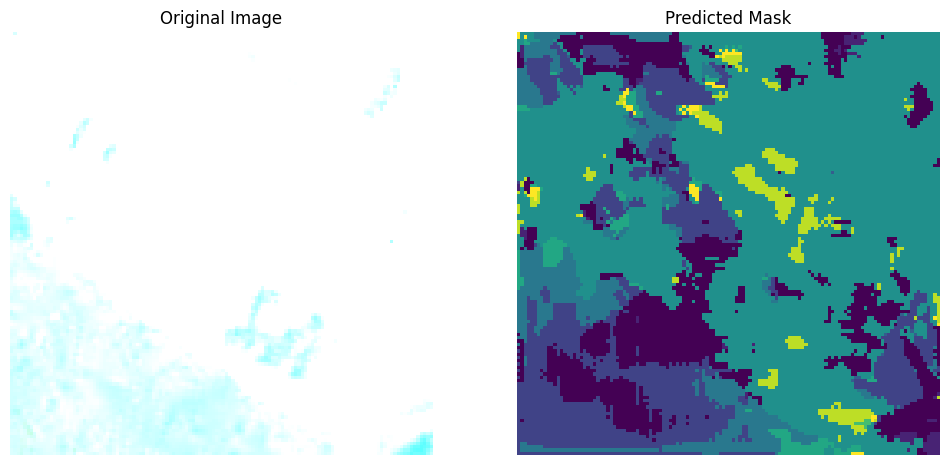

In [125]:
import matplotlib.pyplot as plt


def visualize_prediction(original_image, predicted_mask, figsize=(12, 6)):
    # Assuming original_image is in the format (height, width, channels)
    # and has already been normalized (e.g., pixel values range between 0 and 1)

    # If the original image has more than 3 channels, select the first three for visualization
    if original_image.shape[-1] > 3:
        original_image = original_image[:, :, :3]

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Display the original image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Display the predicted mask
    # Assuming predicted_mask is 2D (height, width), you might want to add a colormap
    axes[1].imshow(predicted_mask, cmap='viridis')  # Use a colormap that suits your task
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')

    plt.show()

# Load your original image and preprocess it for prediction
# Assuming `image` is already loaded and preprocessed for prediction, as shown in the previous steps

# Make a prediction
prediction = model.predict(image)

# Convert prediction to a class mask
predicted_mask = np.argmax(prediction, axis=-1)[0, :, :]  # Remove batch dimension

# Visualize the original image and the prediction
# Note: You might need to adjust the preprocessing of `image` to ensure it's in the correct format for visualization


# adjusted_image = image * factor
adjusted_image = np.clip(image, 0, 1)  # Ensure values are within [0, 1]
visualize_prediction(adjusted_image[0], predicted_mask)

# visualize_prediction(image[0], predicted_mask)  # Pass the first item in the batch


In [107]:
import matplotlib.pyplot as plt
import numpy as np

def adjust_brightness(image, factor):
    """Adjust the brightness of an image by a scaling factor.
    A factor less than 1 will darken the image, and a factor greater than 1 will brighten it.
    """
    adjusted_image = image * factor
    adjusted_image = np.clip(adjusted_image, 0, 1)  # Ensure values are within [0, 1]
    return adjusted_image

def visualize_prediction(original_image, predicted_mask, brightness_factor=0.5, figsize=(12, 6)):
    # Adjust brightness if the image is too bright
    original_image = adjust_brightness(original_image, brightness_factor)

    # If the original image has more than 3 channels, select the first three for visualization
    if original_image.shape[-1] > 3:
        original_image = original_image[:, :, :3]

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # Display the original image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Display the predicted mask
    # Assuming predicted_mask is 2D (height, width), you might want to add a colormap
    axes[1].imshow(predicted_mask, cmap='viridis')  # Use a colormap that suits your task
    axes[1].set_title("Predicted Mask")
    axes[1].axis('off')

    plt.show()

# Assuming `original_image` is your loaded image array and `predicted_mask` is the prediction from your model
# You can adjust brightness_factor to a value that gives the desired visibility
visualize_prediction(original_image, predicted_mask, brightness_factor=0.5)


NameError: name 'original_image' is not defined